In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import os
from IPython.display import Image
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import sklearn.metrics
import joblib
import statsmodels.api as sm

In [2]:
df = pd.read_csv('cardio_train.csv', sep=';')

In [3]:
df.pop('id')
df.head()

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  18393       2     168    62.0    110     80            1     1      0   
1  20228       1     156    85.0    140     90            3     1      0   
2  18857       1     165    64.0    130     70            3     1      0   
3  17623       2     169    82.0    150    100            1     1      0   
4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [4]:
df[['gender', 'cholesterol', 'gluc', 'smoke', 'alco' ,'active', 'cardio']] = df[['gender', 'cholesterol', 'gluc', 'smoke', 'alco' ,'active', 'cardio']].astype(str)


In [5]:
df = df[(df['height'] >= 140) & (df['height'] <= 210)]
acc = {}

In [6]:
df = df[df['ap_hi'] > df['ap_lo']]
df = df[(df['ap_hi'] >= 20) & (df['ap_hi'] <= 300)]
df = df[(df['ap_lo'] >= 20) & (df['ap_lo'] <= 300)]

In [7]:
df['age'] = df['age']/365

In [8]:
df['height'] = df['height']/100

In [9]:
df['bmi'] = df['weight']/df['height']**2

In [10]:
#sns.pairplot(df, hue="cardio", height =3,diag_kind="hist")

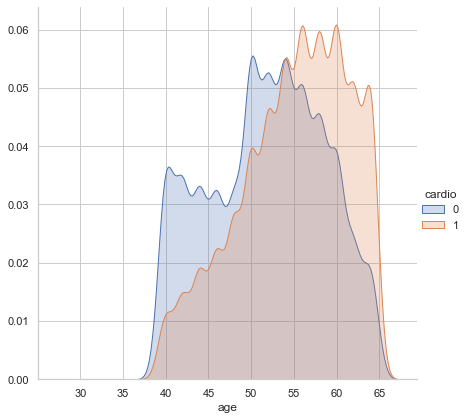

In [11]:
sns.FacetGrid(df, hue="cardio", height=6,).map(sns.kdeplot, "age",shade=True).add_legend()

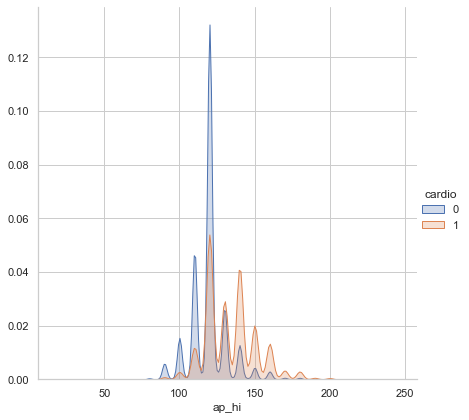

In [12]:
sns.FacetGrid(df, hue="cardio", height=6,).map(sns.kdeplot, "ap_hi",shade=True).add_legend()

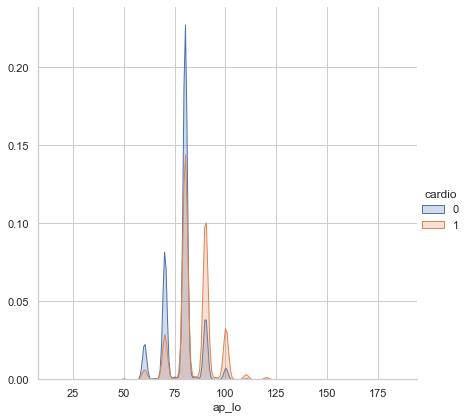

In [13]:
sns.FacetGrid(df, hue="cardio", height=6,).map(sns.kdeplot, "ap_lo",shade=True).add_legend()

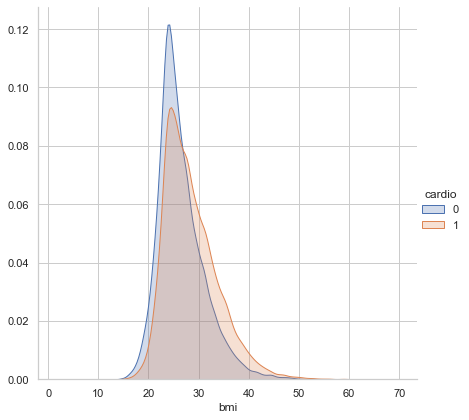

In [14]:
sns.FacetGrid(df, hue="cardio", height=6,).map(sns.kdeplot, "bmi",shade=True).add_legend()

<AxesSubplot:xlabel='gender', ylabel='bmi'>

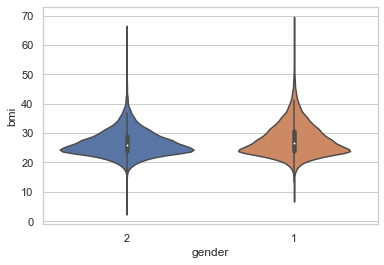

In [15]:
sns.violinplot(x="gender", y="bmi", data=df, height=12)

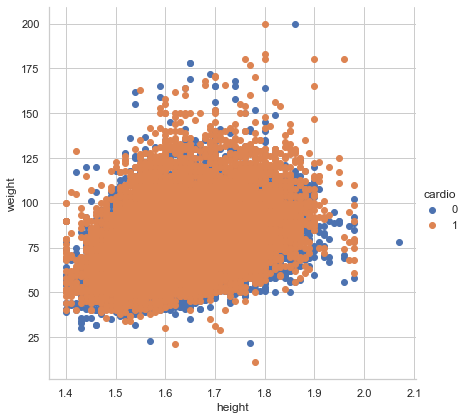

In [16]:
sns.FacetGrid(df, hue="cardio", height=6).map(plt.scatter, "height", "weight").add_legend()

In [17]:
col = ['age', 'gender', 'bmi', 'ap_hi', 'ap_lo','cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio' ]

In [18]:
df = df[col]

In [19]:
X =  df[['age', 'gender', 'bmi', 'ap_hi', 'ap_lo','cholesterol', 'gluc', 'smoke', 'alco', 'active' ]]
y = df['cardio']

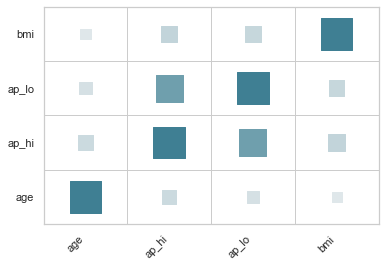

In [20]:


def heatmap(x, y, size, color):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(30, 220, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1]
    
    def value_to_color(val):
        val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
        ind = int(val_position * (n_colors - 1)) # target index in the color palette
        return palette[ind]

    size_scale = 1000
    ax.scatter(
        x=x.map(x_to_num),
        y=y.map(y_to_num),
        s=size * size_scale,
        c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s'
    )
    
    # Show column labels on the axes
    
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    

corr = df[['age','bmi', 'ap_hi', 'ap_lo']].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']

heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color = corr['value']
    )



In [21]:
df[['age','bmi', 'ap_hi', 'ap_lo']].corr()

age       bmi     ap_hi     ap_lo
age    1.000000  0.103766  0.209377  0.155941
bmi    0.103766  1.000000  0.270378  0.242250
ap_hi  0.209377  0.270378  1.000000  0.731133
ap_lo  0.155941  0.242250  0.731133  1.000000

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [23]:
log_model = LogisticRegression(solver='liblinear', random_state=0)
log_model.fit(X_train,y_train)
pred = log_model.predict(X_test).tolist()
true = y_test.tolist()

count = 0
for i in range(len(true)):
    if true[i] == pred[i]:
        count = count + 1

accuracy = count/len(true)
print(f"logistic validation set Accuracy = {accuracy}" )

scores = cross_val_score(log_model, X, y, cv=5)
acc['logistic'] = accuracy

print("Cross validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(classification_report(y, log_model.predict(X)))

logistic validation set Accuracy = 0.7272408963585434
Cross validation Accuracy: 0.73 (+/- 0.01)
              precision    recall  f1-score   support

           0       0.71      0.79      0.75     34628
           1       0.75      0.67      0.71     33916

    accuracy                           0.73     68544
   macro avg       0.73      0.73      0.73     68544
weighted avg       0.73      0.73      0.73     68544



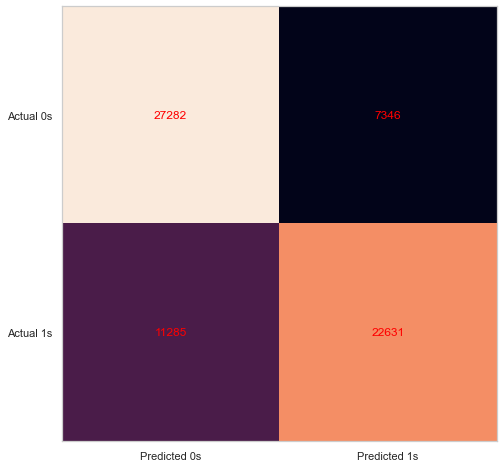

In [24]:
cm = confusion_matrix(y, log_model.predict(X))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

# Logistic moodel with regulerization

In [25]:
log_model2 = LogisticRegression(solver='liblinear', C=10, random_state=0)
log_model2.fit(X_train, y_train)
pred = log_model2.predict(X_test).tolist()
true = y_test.tolist()

count = 0
for i in range(len(true)):
    if true[i] == pred[i]:
        count = count + 1

accuracy = count/len(true)
print(f"Logistic + L1 validation set Accuracy = {accuracy}" )
acc['logistic + l1'] = accuracy
scores = cross_val_score(log_model2, X, y, cv=5)
print("Corss validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(classification_report(y, log_model.predict(X)))

Logistic + L1 validation set Accuracy = 0.7275326797385621
Corss validation Accuracy: 0.73 (+/- 0.01)
              precision    recall  f1-score   support

           0       0.71      0.79      0.75     34628
           1       0.75      0.67      0.71     33916

    accuracy                           0.73     68544
   macro avg       0.73      0.73      0.73     68544
weighted avg       0.73      0.73      0.73     68544



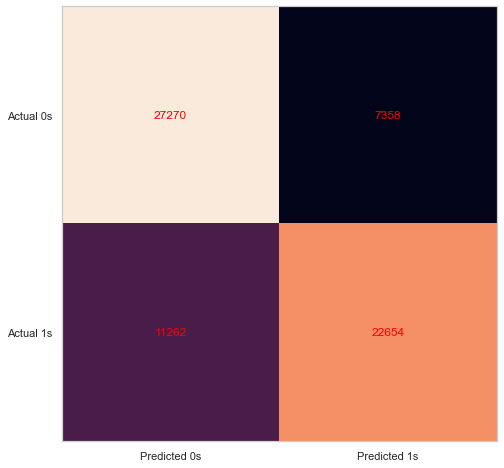

In [26]:
cm = confusion_matrix(y, log_model2.predict(X))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

# Naive bayes model 

In [27]:
Ndata  = df

In [28]:
Ndata.info()
#now using binning to create catagories out of the numerical data 
#numeric data  = age, bmi, ap_hi, ap_lo
#catagorical data = cholesterol, gluc, smoke, alco, active, cardio

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68544 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          68544 non-null  float64
 1   gender       68544 non-null  object 
 2   bmi          68544 non-null  float64
 3   ap_hi        68544 non-null  int64  
 4   ap_lo        68544 non-null  int64  
 5   cholesterol  68544 non-null  object 
 6   gluc         68544 non-null  object 
 7   smoke        68544 non-null  object 
 8   alco         68544 non-null  object 
 9   active       68544 non-null  object 
 10  cardio       68544 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 8.8+ MB


# Using below chart as refrence we will create catagories for high blood pressure 
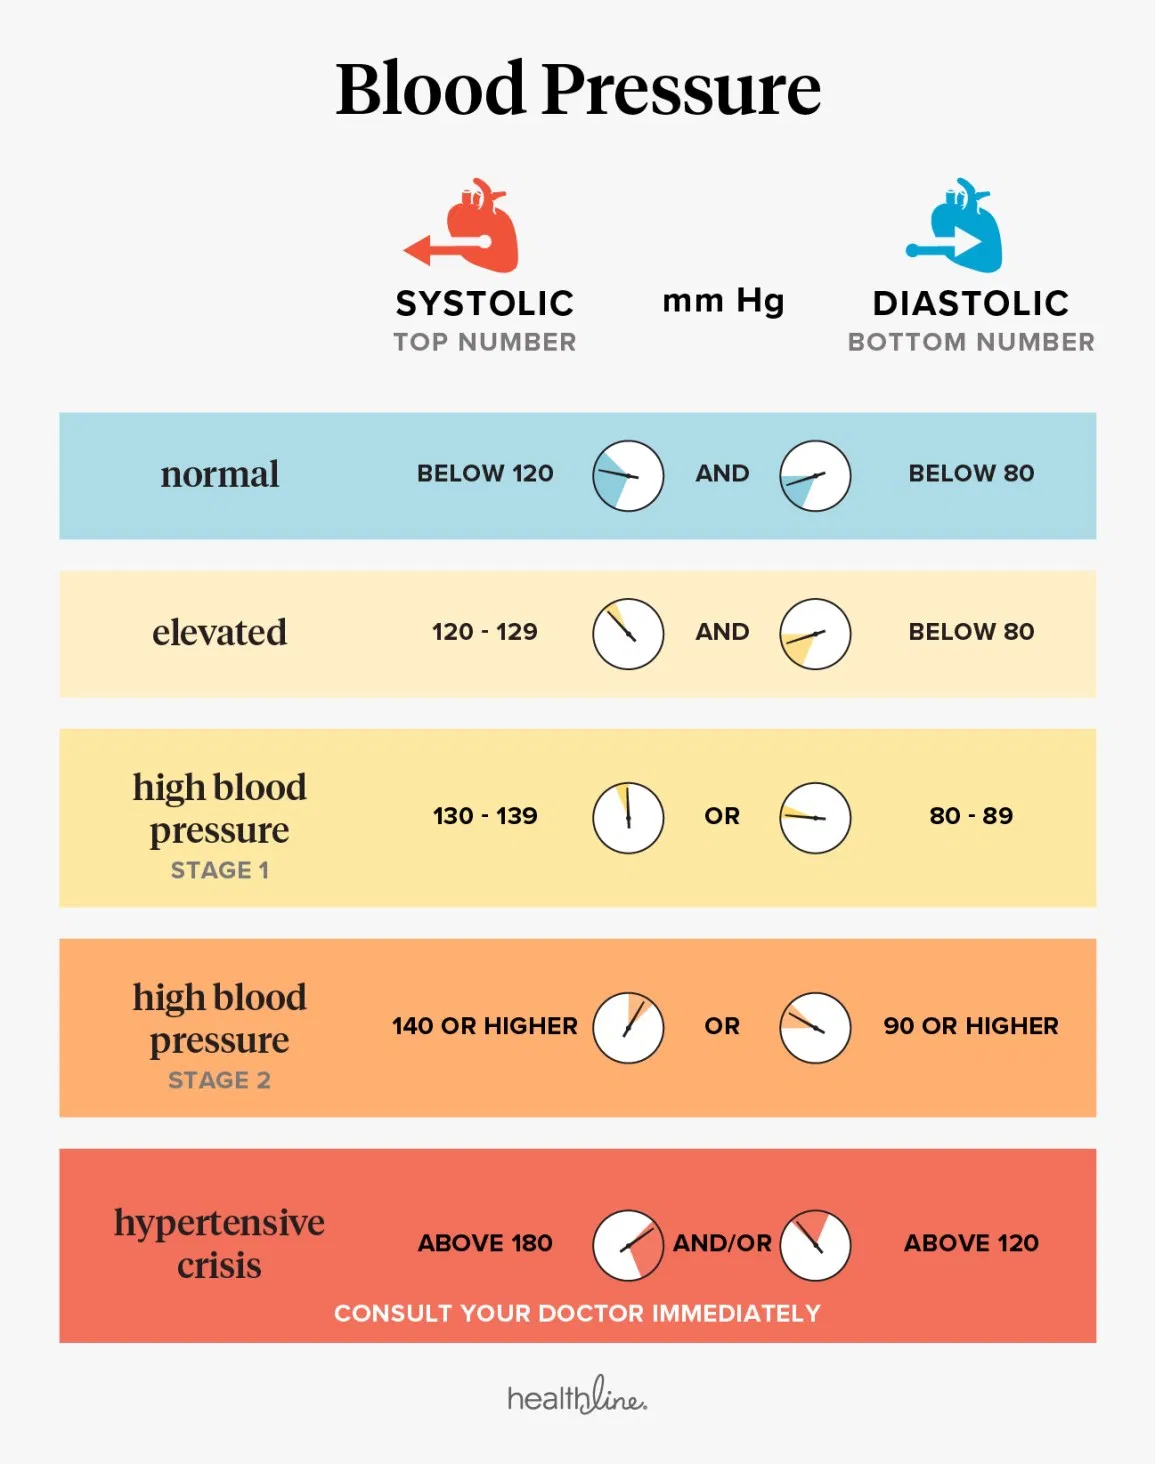

# Using Above chaat as refrence we will create catagories for high blood pressure 

<br> normal = 0 <br> 
<br> elevated = 1 <br> 
<br> stage1 = 2 <br> 
<br> stage2 = 3 <br> 
<br> crsis = 4 <br> 


# Using this char we will create caragories for Bmi column 
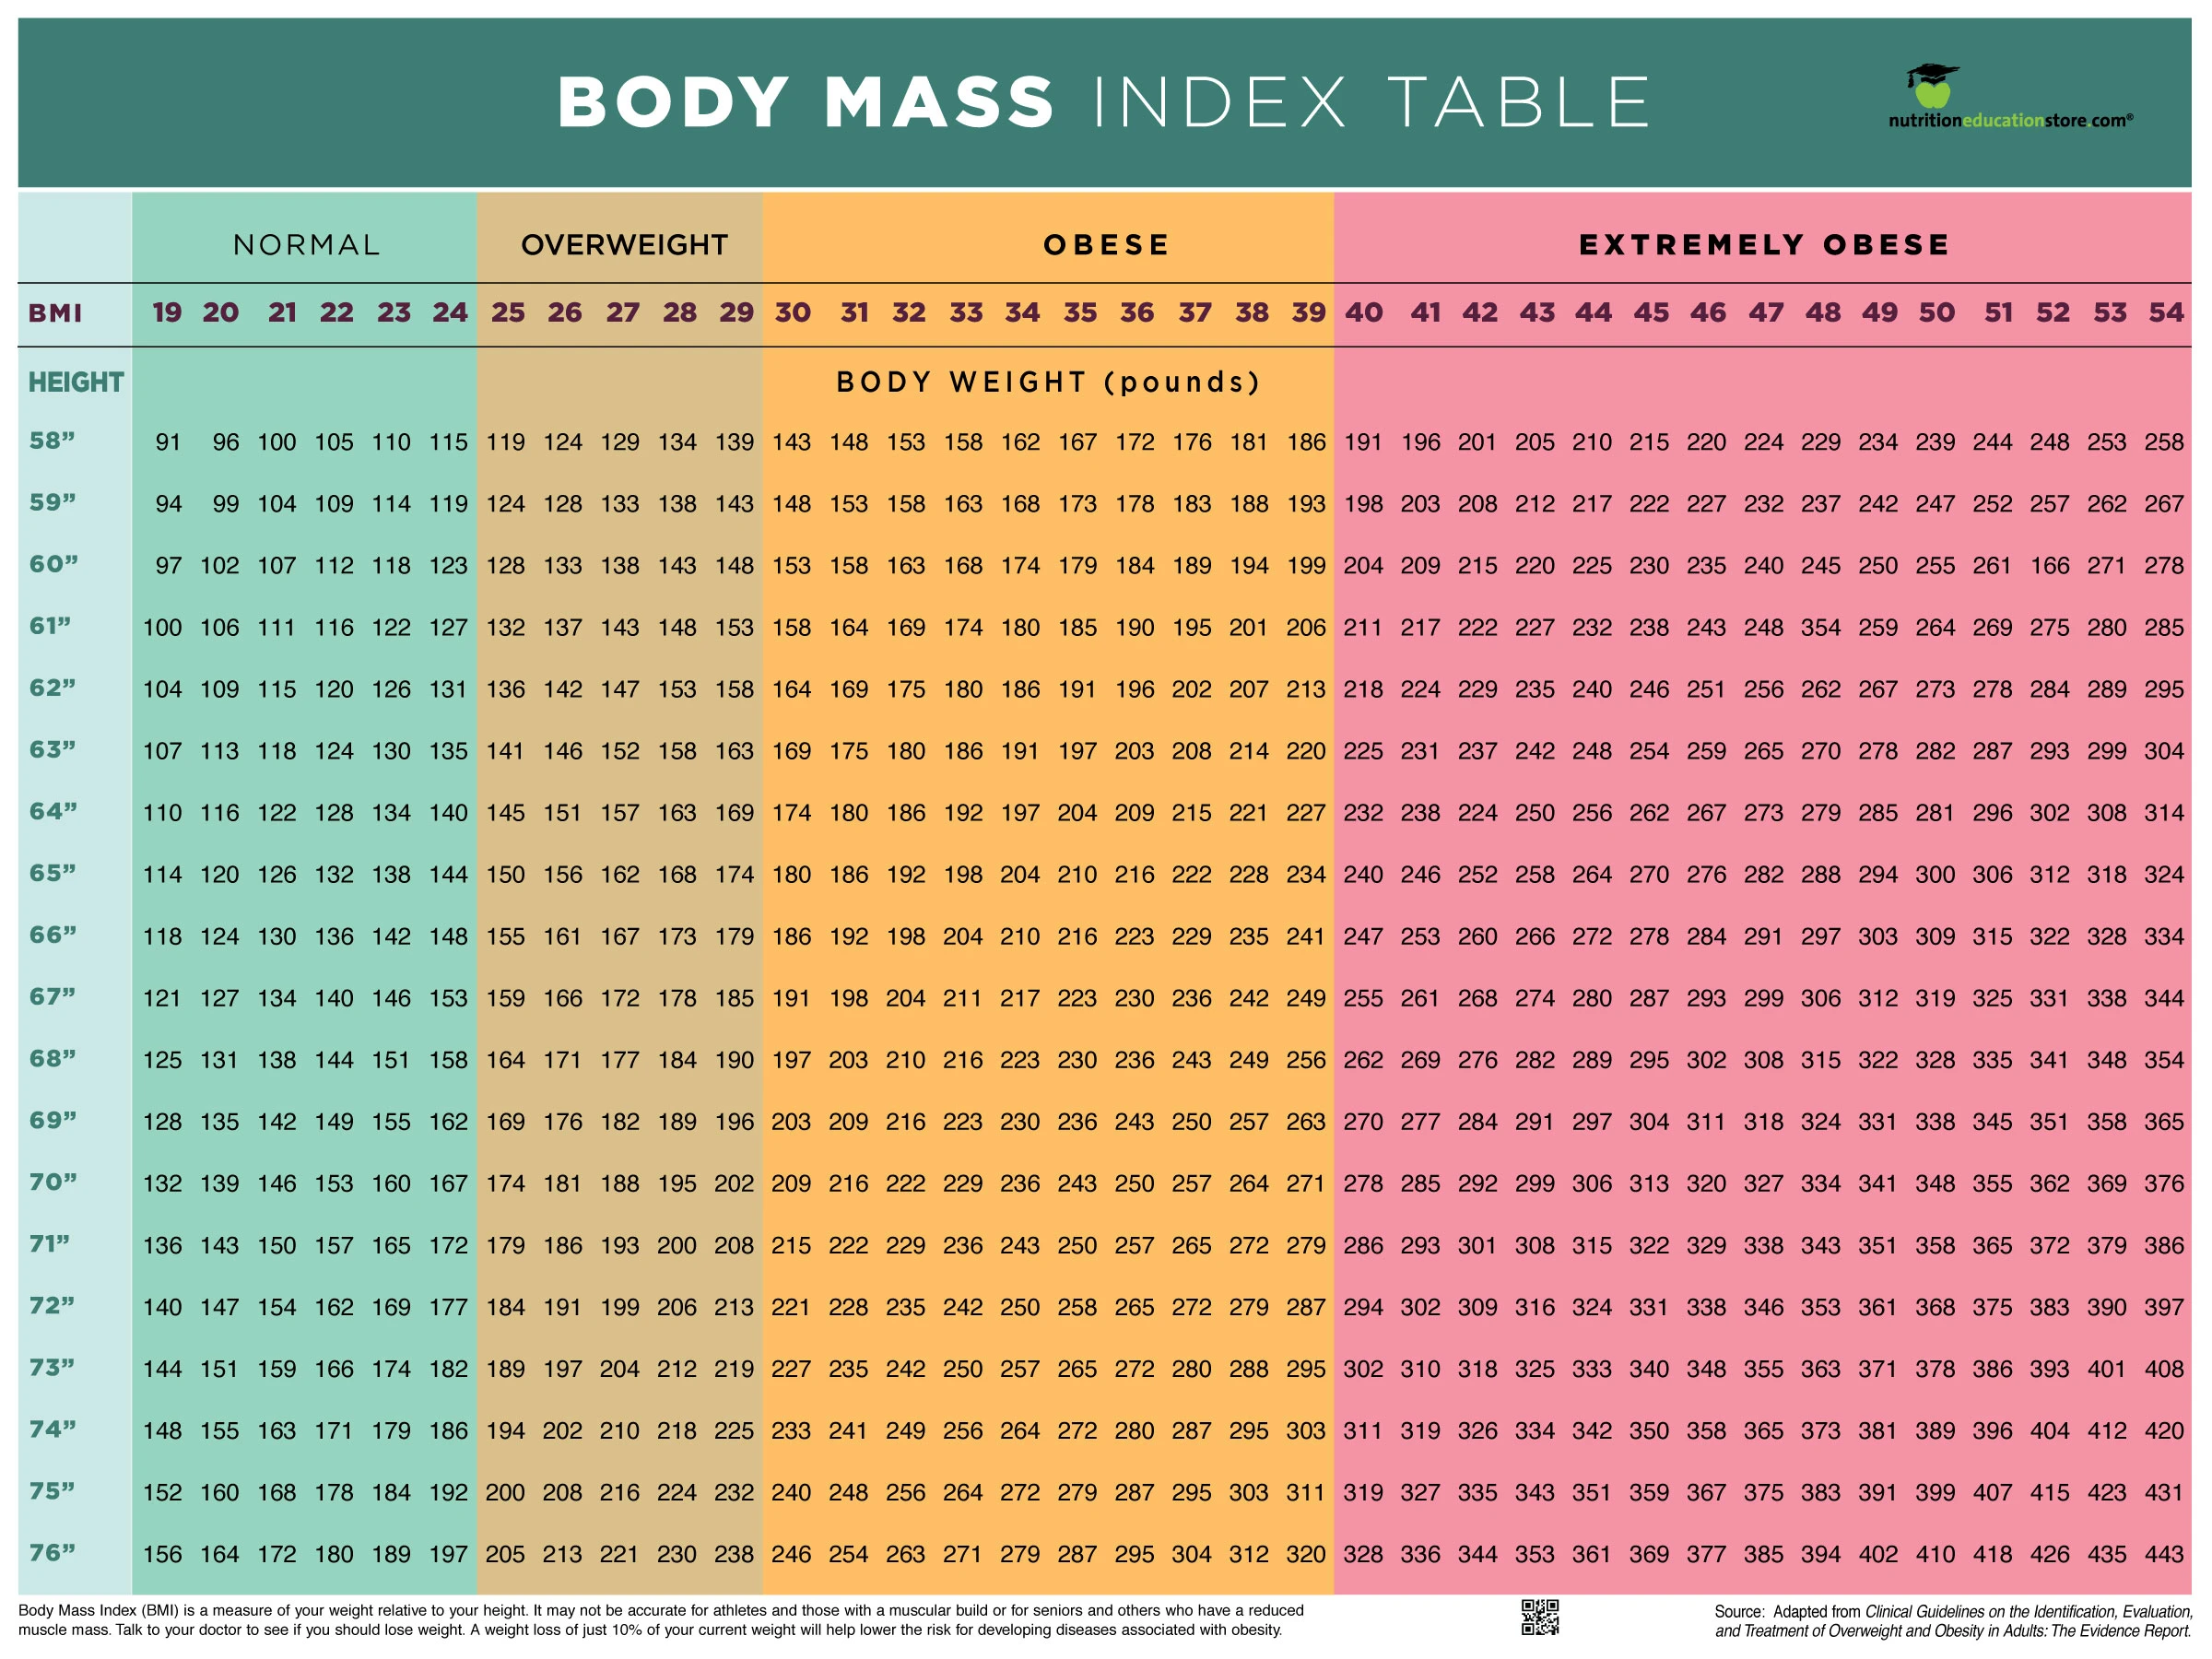

<br> Below 19 = 0 <br> 
<br> 19-24 = 1 <br> 
<br> 25 - 29 = 2 <br> 
<br> 30 - 39 = 3 <br> 
<br> 40 above = 4<br> 

# similerly for age

<br> 0- 20 = 0 <br> 
<br> 20 - 30 = 1 <br> 
<br> 30 - 40 = 2 <br> 
<br> 40 - 50 = 3 <br> 
<br> 50 - 60 = 4 <br> 
<br> 60 above = 5 <br> 

In [29]:
cut_Age = ['0', '1', '2', '3','4','5']
cut_bins = [0, 20, 30, 40, 50, 60, 150]
Ndata['Age1'] = pd.cut(Ndata['age'], bins=cut_bins, labels=cut_Age)


<ipython-input-29-d12b48c190d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ndata['Age1'] = pd.cut(Ndata['age'], bins=cut_bins, labels=cut_Age)


In [30]:
Ndata['Age1'].value_counts()

4    34787
3    19273
5    12723
2     1758
1        3
0        0
Name: Age1, dtype: int64

In [31]:
cut_bmi = ['0', '1', '2', '3','4']
cut_bin_bmi = [0, 19, 24, 29, 39, 150]
Ndata['Bmi1'] = pd.cut(Ndata['bmi'], bins=cut_bin_bmi, labels=cut_bmi)

In [32]:
Ndata['Bmi1'].value_counts()
Ndata.head()

age gender        bmi  ap_hi  ap_lo cholesterol gluc smoke alco  \
0  50.391781      2  21.967120    110     80           1    1     0    0   
1  55.419178      1  34.927679    140     90           3    1     0    0   
2  51.663014      1  23.507805    130     70           3    1     0    0   
3  48.282192      2  28.710479    150    100           1    1     0    0   
4  47.873973      1  23.011177    100     60           1    1     0    0   

  active cardio Age1 Bmi1  
0      1      0    4    1  
1      1      1    4    3  
2      0      1    4    1  
3      1      1    3    2  
4      0      0    3    1

In [33]:
cut_Ap_hi = ['0', '1', '2', '3','4']
cut_bin_Ap_hi = [0, 120, 130, 140, 180, 500]
Ndata['ap_hi1'] = pd.cut(Ndata['ap_hi'], bins=cut_bin_Ap_hi, labels=cut_Ap_hi)

In [34]:
Ndata['ap_hi1'].value_counts()

0    40312
2     9617
1     9479
3     8853
4      283
Name: ap_hi1, dtype: int64

In [35]:
cut_Ap_lo = ['0', '1', '2', '3']
cut_bin_Ap_lo = [0, 80, 90, 120, 500]
Ndata['ap_lo1'] = pd.cut(Ndata['ap_lo'], bins=cut_bin_Ap_lo, labels=cut_Ap_lo)

In [36]:
Ndata['ap_lo1'].value_counts()

0    48665
1    14840
2     4994
3       45
Name: ap_lo1, dtype: int64

In [37]:
Ndata.head()

age gender        bmi  ap_hi  ap_lo cholesterol gluc smoke alco  \
0  50.391781      2  21.967120    110     80           1    1     0    0   
1  55.419178      1  34.927679    140     90           3    1     0    0   
2  51.663014      1  23.507805    130     70           3    1     0    0   
3  48.282192      2  28.710479    150    100           1    1     0    0   
4  47.873973      1  23.011177    100     60           1    1     0    0   

  active cardio Age1 Bmi1 ap_hi1 ap_lo1  
0      1      0    4    1      0      0  
1      1      1    4    3      2      1  
2      0      1    4    1      1      0  
3      1      1    3    2      3      2  
4      0      0    3    1      0      0

In [38]:
col = ['Age1', 'gender', 'Bmi1', 'ap_hi1', 'ap_lo1','cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio' ]

In [39]:
Ndata = Ndata[col]

In [40]:
Ndata.describe()

Age1 gender   Bmi1 ap_hi1 ap_lo1 cholesterol   gluc  smoke   alco  \
count   68544  68544  68544  68544  68544       68544  68544  68544  68544   
unique      5      2      5      5      4           3      3      2      2   
top         4      1      2      0      0           1      1      0      0   
freq    34787  44640  28386  40312  48665       51396  58277  62512  64885   

       active cardio  
count   68544  68544  
unique      2      2  
top         1      0  
freq    55074  34628

In [70]:
X =  df[['Age1', 'gender', 'Bmi1', 'ap_hi1', 'ap_lo1','cholesterol', 'gluc', 'smoke', 'alco', 'active' ]]
y = df['cardio']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [43]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 50)
classifier.fit(X_train,y_train)
pred = classifier.predict(X_test).tolist()
true = y_test.tolist()

count = 0
for i in range(len(true)):
    if true[i] == pred[i]:
        count = count + 1

accuracy = count/len(true)
print(f"random forest validation set Accuracy = {accuracy}" )
acc['Random forest'] = accuracy
scores = cross_val_score(classifier, X, y, cv=5)
print("Cross validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(classification_report(y, classifier.predict(X)))

random forest validation set Accuracy = 0.7146942110177404
Cross validation Accuracy: 0.72 (+/- 0.01)
              precision    recall  f1-score   support

           0       0.71      0.81      0.76     34628
           1       0.77      0.66      0.71     33916

    accuracy                           0.74     68544
   macro avg       0.74      0.74      0.74     68544
weighted avg       0.74      0.74      0.74     68544



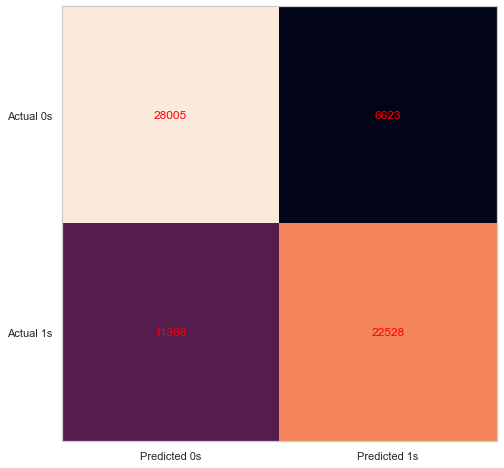

In [71]:
cm = confusion_matrix(y, classifier.predict(X))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [44]:
from sklearn.svm import SVC # "Support vector classifier"
SVC_model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
SVC_model.fit(X_train,y_train)
pred = SVC_model.predict(X_test).tolist()
true = y_test.tolist()

count = 0
for i in range(len(true)):
    if true[i] == pred[i]:
        count = count + 1

accuracy = count/len(true)
print(f"SVM validation set Accuracy = {accuracy}" )
acc['SVM'] = accuracy
scores = cross_val_score(SVC_model, X, y, cv=5)
print("Cross validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(classification_report(y, SVC_model.predict(X)))
confusion_matrix(y, SVC_model.predict(X))

SVM validation set Accuracy = 0.7248482726423903
Cross validation Accuracy: 0.73 (+/- 0.00)
              precision    recall  f1-score   support

           0       0.71      0.77      0.74     34628
           1       0.75      0.69      0.71     33916

    accuracy                           0.73     68544
   macro avg       0.73      0.73      0.73     68544
weighted avg       0.73      0.73      0.73     68544



array([[26695,  7933],
       [10677, 23239]], dtype=int64)

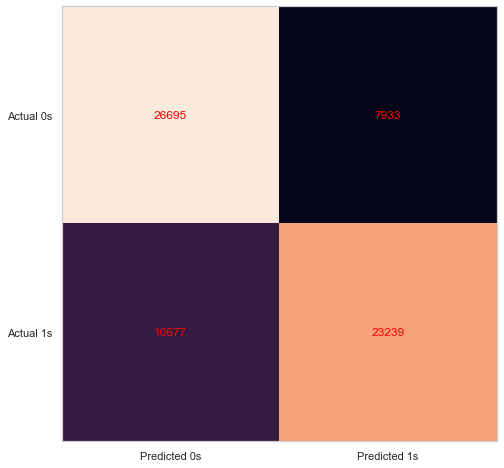

In [75]:
cm = confusion_matrix(y,SVC_model.predict(X))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [45]:
from sklearn.naive_bayes import GaussianNB
model_GBN = GaussianNB()
model_GBN.fit(X_train,y_train)

pred = model_GBN.predict(X_test).tolist()
true = y_test.tolist()

count = 0
for i in range(len(true)):
    if true[i] == pred[i]:
        count = count + 1

accuracy = count/len(true)
print("NAVIE BAYES accuracy=",accuracy)
acc['NAVIE BAYES'] = accuracy
scores = cross_val_score(model_GBN, X, y, cv=5)
print("Cross validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(classification_report(y, model_GBN.predict(X)))
print(confusion_matrix(y, model_GBN.predict(X)))

NAVIE BAYES accuracy= 0.7182247899159664
Cross validation Accuracy: 0.72 (+/- 0.00)
              precision    recall  f1-score   support

           0       0.68      0.82      0.75     34628
           1       0.77      0.61      0.68     33916

    accuracy                           0.72     68544
   macro avg       0.73      0.72      0.71     68544
weighted avg       0.73      0.72      0.71     68544

[[28463  6165]
 [13173 20743]]


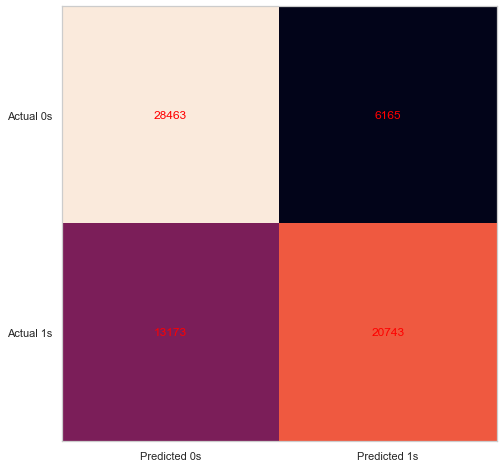

In [72]:
cm = confusion_matrix(y, model_GBN.predict(X))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [46]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

model_dt = DecisionTreeClassifier()
model_dt.fit(X_train,y_train)

pred = model_dt.predict(X_test).tolist()
true = y_test.tolist()

count = 0
for i in range(len(true)):
    if true[i] == pred[i]:
        count = count + 1

accuracy = count/len(true)
print("decision tree =",accuracy)
acc['Decison tree'] = accuracy
scores = cross_val_score(model_dt, X, y, cv=5)
print("Cross validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(classification_report(y, model_dt.predict(X)))
print(confusion_matrix(y, model_dt.predict(X)))

decision tree = 0.7062616713352008
Cross validation Accuracy: 0.71 (+/- 0.01)
              precision    recall  f1-score   support

           0       0.70      0.83      0.76     34628
           1       0.78      0.64      0.70     33916

    accuracy                           0.73     68544
   macro avg       0.74      0.73      0.73     68544
weighted avg       0.74      0.73      0.73     68544

[[28584  6044]
 [12254 21662]]


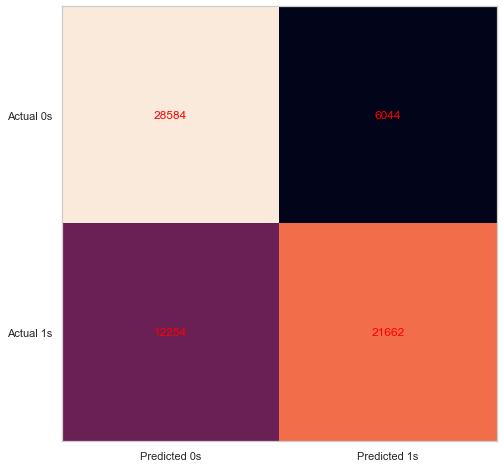

In [73]:
cm = confusion_matrix(y,model_dt.predict(X))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [47]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

model_dt2 = DecisionTreeClassifier(max_depth = 4)
model_dt2.fit(X_train,y_train)

pred = model_dt2.predict(X_test).tolist()
true = y_test.tolist()

count = 0
for i in range(len(true)):
    if true[i] == pred[i]:
        count = count + 1

accuracy = count/len(true)
print("decision tree =",accuracy)

scores = cross_val_score(model_dt2, X, y, cv=5)
print("Cross validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

decision tree = 0.7194794584500467
Cross validation Accuracy: 0.72 (+/- 0.01)


In [48]:
!dot -Tpng model_dt2.dot -o dt2.png

In [49]:
with open("model_dt2.dot", 'w') as f:
    export_graphviz(model_dt2, out_file=f, feature_names=X.columns)

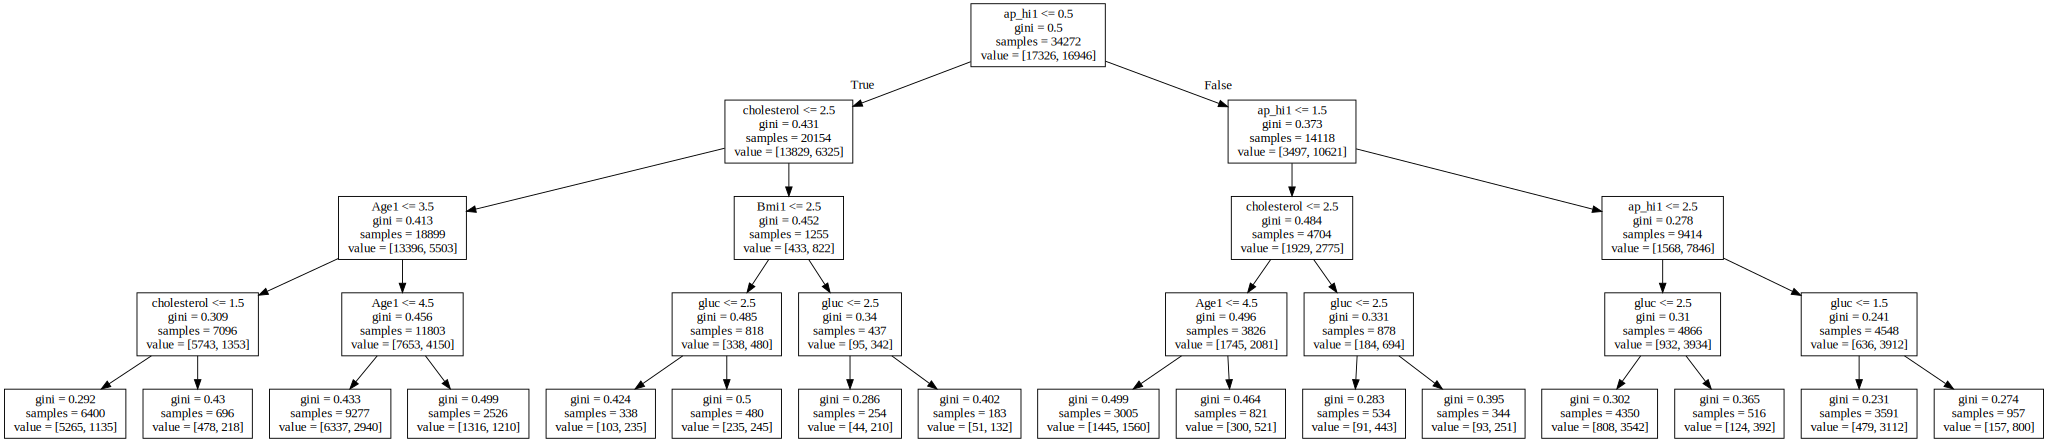

In [50]:
import graphviz
from IPython.display import display
with open("model_dt2.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))


# Neural network model

In [51]:
NN_model = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)

In [52]:
NN_model.fit(X, y)
pred = NN_model.predict(X_test).tolist()
true = y_test.tolist()

count = 0
for i in range(len(true)):
    if true[i] == pred[i]:
        count = count + 1

accuracy = count/len(true)
print(f"validation set approach Accuracy = {accuracy}" )
acc['NN'] = accuracy
scores = cross_val_score(NN_model, X, y, cv=5)
print("Cross validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(classification_report(y, NN_model.predict(X)))
print(confusion_matrix(y, NN_model.predict(X)))

validation set approach Accuracy = 0.7292833800186741
Cross validation Accuracy: 0.73 (+/- 0.01)
              precision    recall  f1-score   support

           0       0.72      0.78      0.74     34628
           1       0.75      0.69      0.72     33916

    accuracy                           0.73     68544
   macro avg       0.73      0.73      0.73     68544
weighted avg       0.73      0.73      0.73     68544

[[26850  7778]
 [10671 23245]]


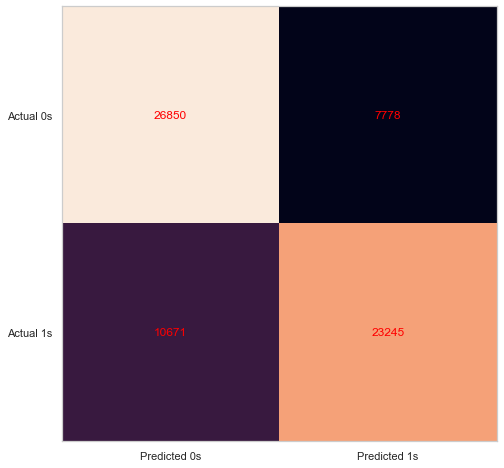

In [74]:
cm = confusion_matrix(y,NN_model.predict(X))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

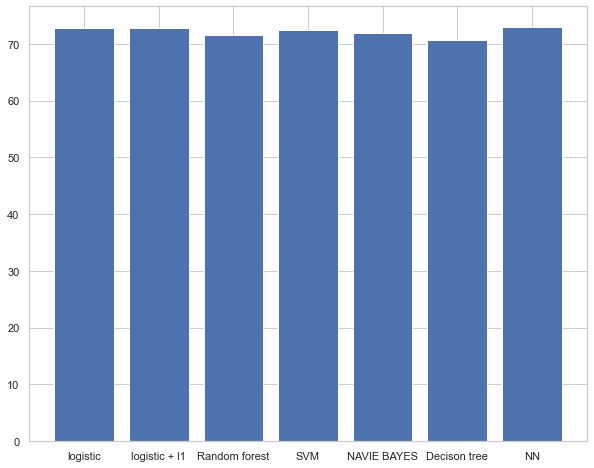

In [83]:
lists = (acc.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
fig, ax = plt.subplots(figsize=(10, 8))
plt.bar(x, [i*100 for i in y])
plt.show()


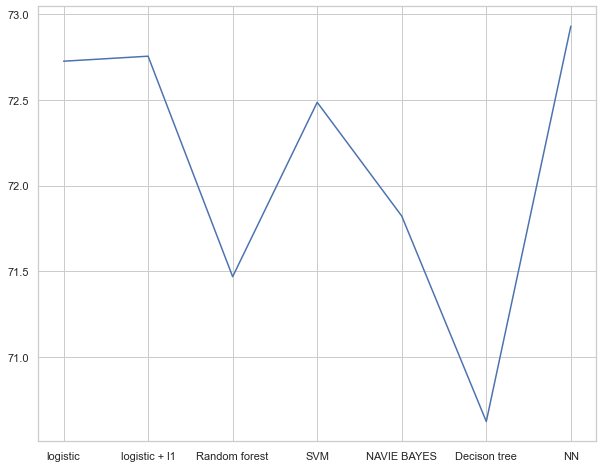

In [84]:
lists = (acc.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(x, [i*100 for i in y])
plt.show()

In [54]:
acc

{'logistic': 0.7272408963585434,
 'logistic + l1': 0.7275326797385621,
 'Random forest': 0.7146942110177404,
 'SVM': 0.7248482726423903,
 'NAVIE BAYES': 0.7182247899159664,
 'Decison tree': 0.7062616713352008,
 'NN': 0.7292833800186741}

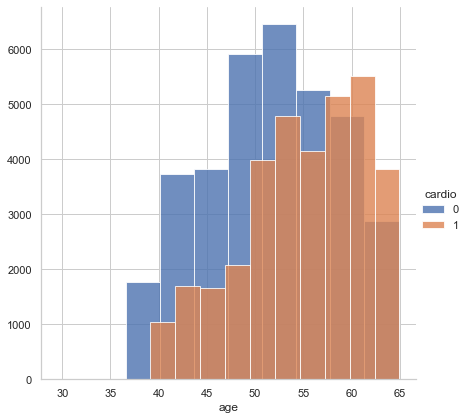

In [55]:
sns.FacetGrid(df, hue="cardio", height=6).map(plt.hist, "age" , alpha = 0.8).add_legend()

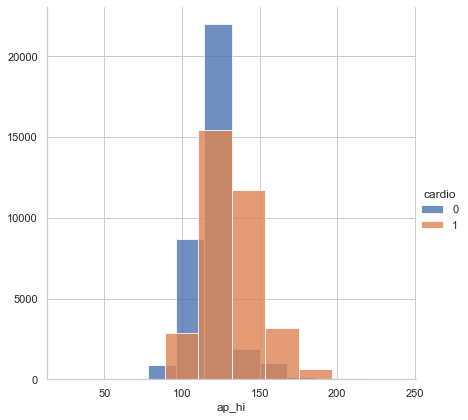

In [56]:
sns.FacetGrid(df, hue="cardio", height=6).map(plt.hist, "ap_hi", alpha = 0.8).add_legend()

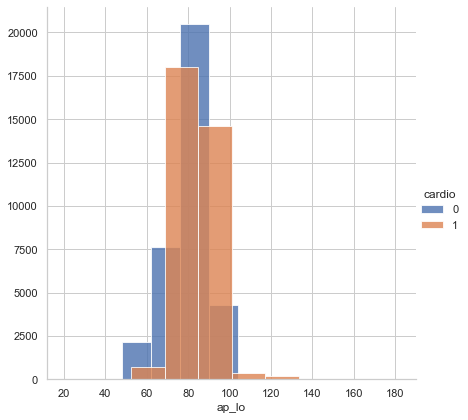

In [57]:
sns.FacetGrid(df, hue="cardio", height=6).map(plt.hist, "ap_lo", alpha = 0.8).add_legend()

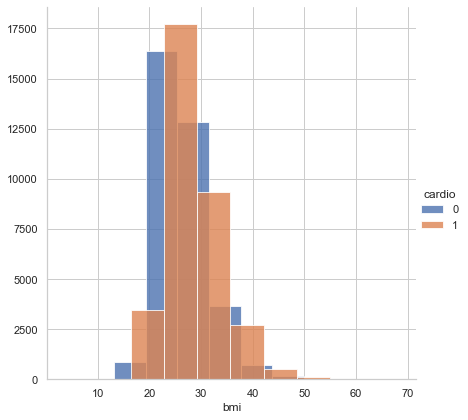

In [58]:
sns.FacetGrid(df, hue="cardio", height=6).map(plt.hist, "bmi", alpha = 0.8).add_legend()

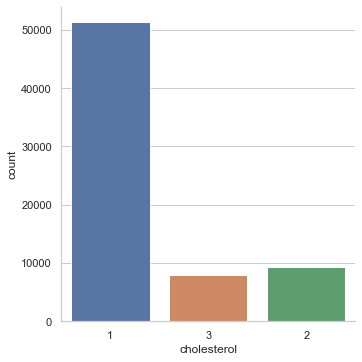

In [59]:
sns.catplot(x="cholesterol", kind = 'count', data=df)

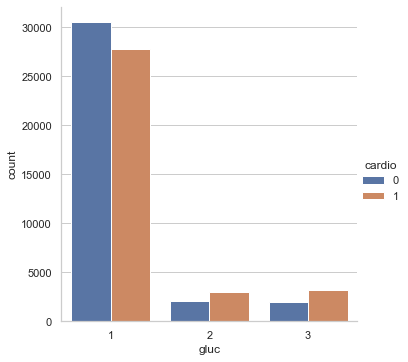

In [60]:
sns.catplot(x="gluc", hue = 'cardio',kind = 'count' ,
            data=df )

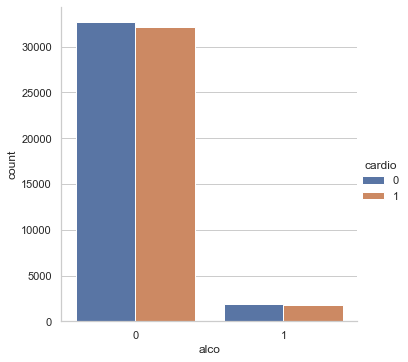

In [61]:
sns.catplot(x="alco", hue = 'cardio',kind = 'count' ,
            data=df )

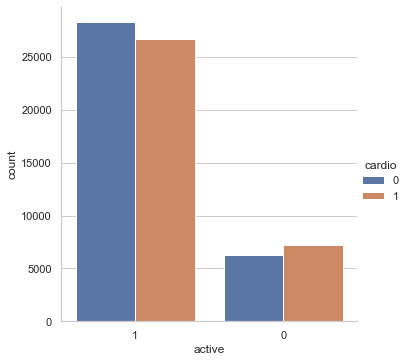

In [62]:
sns.catplot(x="active", hue = 'cardio',kind = 'count' ,
            data=df )

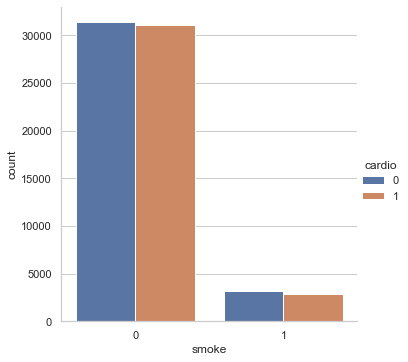

In [63]:
sns.catplot(x="smoke", hue = 'cardio',kind = 'count' ,
            data=df )

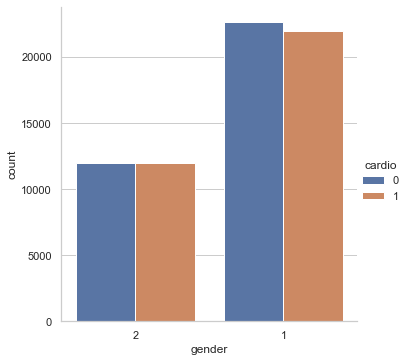

In [64]:
sns.catplot(x="gender", hue = 'cardio',kind = 'count' ,
            data=df )

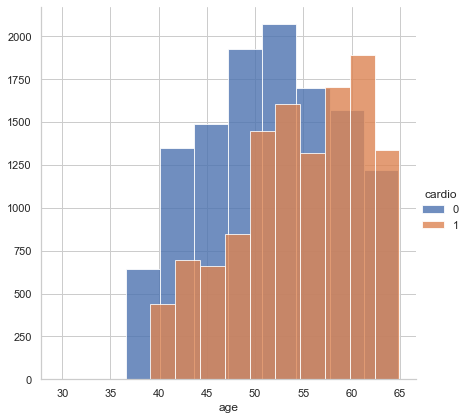

In [65]:
sns.FacetGrid(df[df['gender'] == '2'], hue="cardio", height=6).map(plt.hist, "age", alpha = 0.8).add_legend()

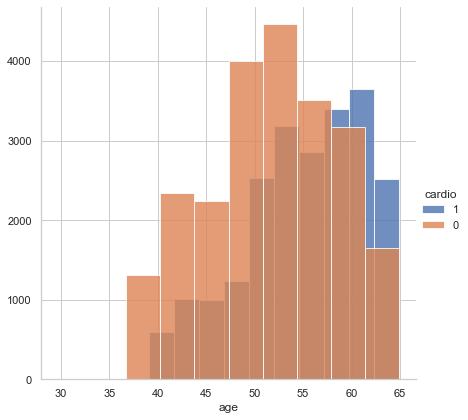

In [66]:
sns.FacetGrid(df[df['gender'] == '1'], hue="cardio", 
              height=6).map(plt.hist, "age", alpha = 0.8).add_legend()

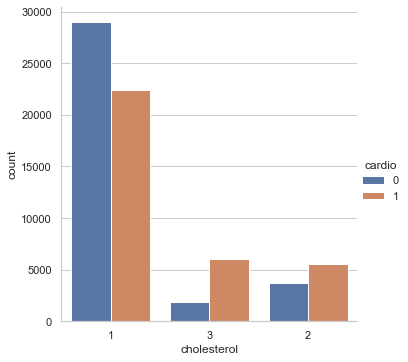

In [67]:
sns.catplot(x="cholesterol", hue = 'cardio',kind = 'count' ,
            data=df )

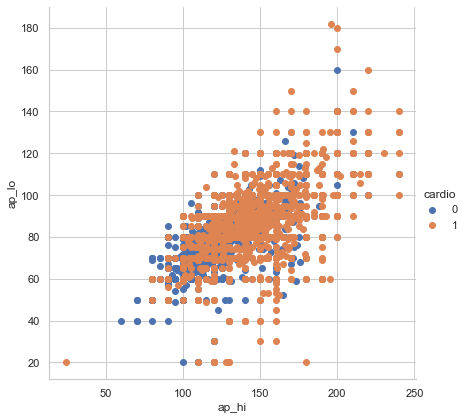

In [68]:
sns.FacetGrid(df, hue="cardio", height=6).map(plt.scatter, "ap_hi", "ap_lo").add_legend()